&nbsp; 
  
#  <center>The Imperfect Umpire Model</center>
## <center>Can we use Statcast data to predict MLB umpire mistakes?</center>
##### <center>University of Colorado Boulder | Introduction to Deep Learning - Final Project</center>
##### <center>Jeremy Hurley | March, 2025</center>

&nbsp;  

---  

&nbsp;  

# Project statement
This project will build off of the work that I did for the Unsupervised Learning final where I grouped umpires into clusters based on favorability towards hitters or pitchers. This project will take it a step further and try to predict if a pitch will be misclassified as a ball or strike based on the pitch metrics.  

For instance, given the speed, release point, pitch type and where the pitch crosses home plate (among other things), are we able to predict that an umpire might call a ball that is technically in the strike zone a ball? Or vica-versa?

# Introduction: 
In Major League Baseball (MLB), determining balls and strikes is one of the most fundamental, yet important parts of the game. For those that aren't familiar with the rules of baseball, a pitch is called a strike if it crosses home plate within a designated strike zone. MLB defines the strike zone as:  
  
> the area over home plate from the midpoint between a batter's shoulders and the top of the uniform pants -- when the batter is in his stance and prepared to swing at a pitched ball -- and a point just below the kneecap.

One of the longstanding issues in baseball is that balls and strikes are subject to human error and interpretation. Pitches, some of which can reach 105 MPH, while moving both vertically and laterally, are called by human umpires who are standing behind the catcher. Generally, MLB umpires do an amazing job calling pitches, but they do miss one every now and then and, depending on the situation, the consequences can be substantial.  
  
The data for this project was generated by Statcast, which is an advanced tracking system introduced by the MLB in 2015. Statcast uses radar and optical cameras to record metric information on every play of every game in the MLB, including ball velocity, spin rates, launch angles and player movements.  

  
&nbsp;  

---  

&nbsp;  
  

# Data:  
The data for this project was pulled from the pybaseball Python package.    
  
The pybaseball Python package was developed by James LeDoux. It pulls data from multiple data sources, including FanGraphs, Baseball Reference and Baseball Savant. It contains a vast amount of data from every MLB game played in the modern era. For more information on pybaseball, find it's GitHub repo [here](https://github.com/jldbc/pybaseball)  
  
The umpire column in the Statcast data was not populated (possibly depricated), so I was able to find home plate umpire for each game in the 2023 season [here](https://umpscorecards.com/games/)  
  
Steps and descriptions of data acquisition, cleaning and saving can be found in the supplemental data notebook titled *'The Umpire Model - Data'*.  
  
This project starts by importing the dataset prepared and saved in the supplemental data notebook. Each row of the dataset represents one pitch in the 2023 MLB baseball season. Further, the dataset has been filtered to include only pitches that resulted in a ball or a called strike. Please reference the supplemental data notebook for the logic and process for creating the dataset.

In [2]:
import pandas as pd

# Load CSV file prepared in previous notebook
data = pd.read_csv('2023_strike_ball_data_with_umpires.csv')
data = data.dropna(subset=['release_speed'])

# Verify import
data.head()

,home_team,away_team,game_date,player_name,batter,pitcher,plate_x,plate_z,pitch_type,zone,...,pfx_x,pfx_z,plate_x.1,plate_z.1,on_3b,on_2b,on_1b,outs_when_up,pitch_name,umpire
0,NYM,PHI,2023-09-30,"Smith, Drew",664761,622098,1.24,1.57,SL,14,...,0.48,-0.11,1.24,1.57,NaN,NaN,NaN,2,Slider,Quinn Wolcott
1,NYM,PHI,2023-09-30,"Smith, Drew",656941,622098,0.76,0.78,CH,14,...,-1.37,0.82,0.76,0.78,NaN,NaN,NaN,0,Changeup,Quinn Wolcott
2,NYM,PHI,2023-09-30,"Smith, Drew",656941,622098,-1.29,4.77,CU,11,...,1.26,-0.65,-1.29,4.77,NaN,NaN,NaN,0,Curveball,Quinn Wolcott
3,NYM,PHI,2023-09-30,"Sánchez, Cristopher",677595,650911,0.37,0.20,CH,14,...,1.51,0.11,0.37,0.20,NaN,NaN,NaN,1,Changeup,Quinn Wolcott
4,NYM,PHI,2023-09-30,"Sánchez, Cristopher",677595,650911,-1.06,2.70,SI,13,...,1.55,0.06,-1.06,2.70,NaN,NaN,NaN,1,Sinker,Quinn Wolcott


In [3]:
# Get column and row count information
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 350478 entries, 0 to 350478
Data columns (total 32 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   home_team      350478 non-null  object 
 1   away_team      350478 non-null  object 
 2   game_date      350478 non-null  object 
 3   player_name    350478 non-null  object 
 4   batter         350478 non-null  int64  
 5   pitcher        350478 non-null  int64  
 6   plate_x        350478 non-null  float64
 7   plate_z        350478 non-null  float64
 8   pitch_type     350478 non-null  object 
 9   zone           350478 non-null  int64  
 10  sz_top         350478 non-null  float64
 11  sz_bot         350478 non-null  float64
 12  type           350478 non-null  int64  
 13  release_speed  350478 non-null  float64
 14  release_pos_x  350478 non-null  float64
 15  release_pos_z  350478 non-null  float64
 16  release_pos_y  350478 non-null  float64
 17  description    350478 non-null  ob

# Exploratory Data Analysis:
Exploratory data analysis for this project will start by examining the balance between balls and strikes and a visualization of pitch locations.  
  
  

Percent of strikes: 0.33


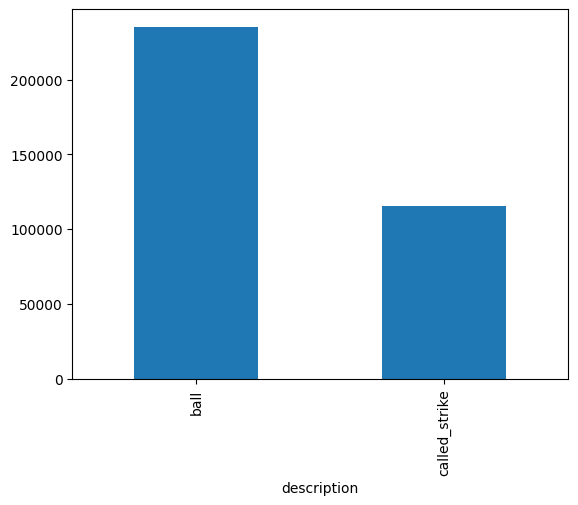

In [4]:
# Check for balance between balls and strikes.
data['description'].value_counts().plot(kind='bar')

# Mean of 'type' column will give % of strikes
print(f'Percent of strikes: {data['type'].mean():.2}')

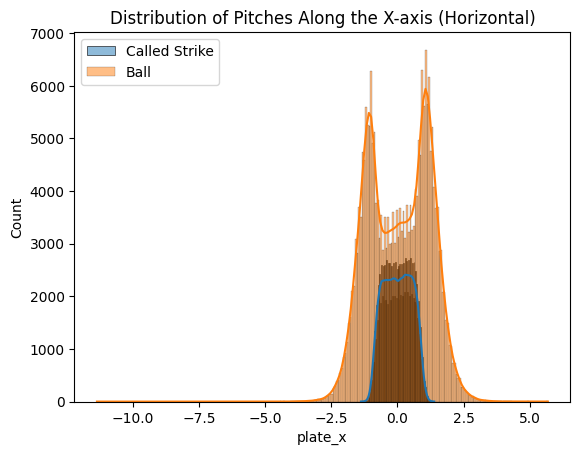

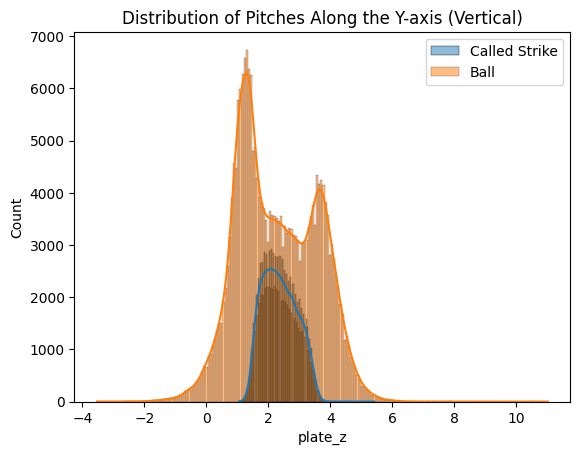

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data[data['type'] == 1]['plate_x'], label='Called Strike', kde=True)
sns.histplot(data[data['type'] == 0]['plate_x'], label='Ball', kde=True)
plt.legend()
plt.title('Distribution of Pitches Along the X-axis (Horizontal)')
plt.show()

sns.histplot(data[data['type'] == 1]['plate_z'], label='Called Strike', kde=True)
sns.histplot(data[data['type'] == 0]['plate_z'], label='Ball', kde=True)
plt.legend()
plt.title('Distribution of Pitches Along the Y-axis (Vertical)')
plt.show()

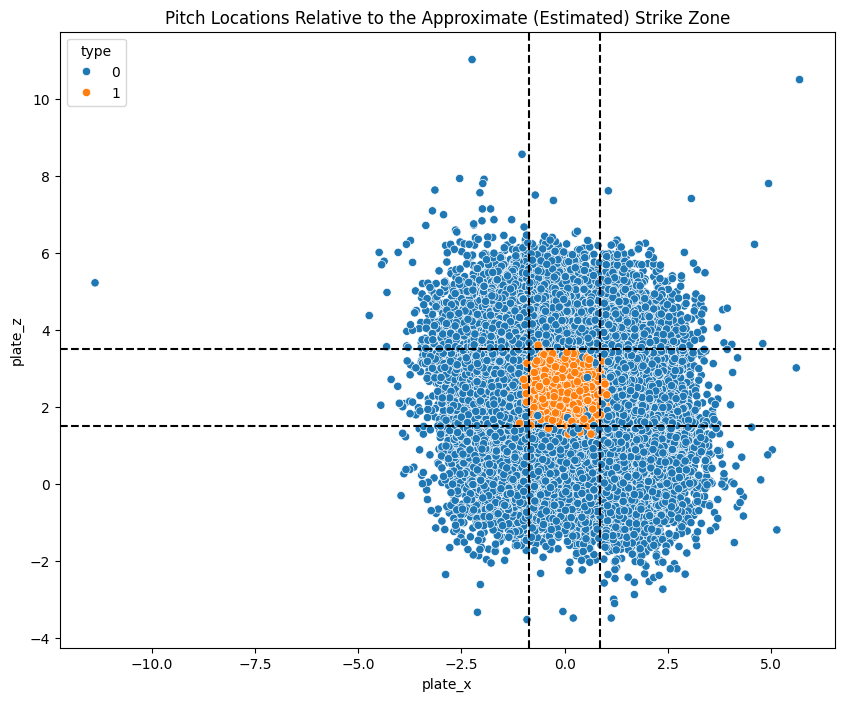

In [6]:
plt.figure(figsize=(10,8))
sns.scatterplot(x='plate_x', y='plate_z', hue='type', data=data)
plt.title('Pitch Locations Relative to the Approximate (Estimated) Strike Zone')
plt.axvline(x=0.85, color='black', linestyle='--')
plt.axvline(x=-0.85, color='black', linestyle='--')
plt.axhline(y=1.5, color='black', linestyle='--')
plt.axhline(y=3.5, color='black', linestyle='--')
plt.show()

## Exploratory Data Analysis - Preliminary Results:  
I learned two important insights about the data as a result of the EDA.  

- Balls outweigh strikes by about 2:1.
- There is a lot of noise outside what might reasonably be called a strike by an umpire.

For this project we are only interested in pitches that are close to the edge of the strike zone. I think a good limit is within 4 inches of the x and z coordinates of the strike zone.  

Therefore, I'm going to remove rows that don't fit the following:

- Remove rows where plate_z is outside 'sz_top' +/- 0.25 and outside 'sz_bot' +/- 0.25 (0.25 = 3 inches)
- Remove rows where 0.58 <= |plate_x| <= 1.08

Filtering this data keeps pitches that are within 3 inches of the edge of the strike zone in any direction.

**Note:** I will use +/- 0.83 as the horizontal width of the strike zone. This accounts for the size of home plate and the width of the baseball. Further, I will use sz_bot and sz_top as the actual top and bottom of the strike zone as measured by statcast.

In [29]:
close_calls = data[
    (
        # Horizontal boundary condition
        ((data['plate_x'].abs() >= 0.58) & (data['plate_x'].abs() <= 1.08)) & 
        ((data['plate_z'] <= data['sz_top'] + 0.25) & (data['plate_z'] >= data['sz_bot'] - 0.25))
    ) 
    |
    ((
        # Vertical boundary condition
        ((data['plate_z'] >= data['sz_top'] - 0.25) & (data['plate_z'] <= data['sz_top'] + 0.25)) |
        ((data['plate_z'] >= data['sz_bot'] - 0.25) & (data['plate_z'] <= data['sz_bot'] + 0.25))
    ) 
    &
    (data['plate_x'].abs() <= 1.08))  # Keep pitches near horizontal boundary
]
# Mean of 'type' column will give % of strikes
print(f'Percent of strikes: {close_calls['type'].mean():.2}')
print(f'Shape of new dataset: {close_calls.shape}')

Percent of strikes: 0.56
Shape of new dataset: (115924, 32)


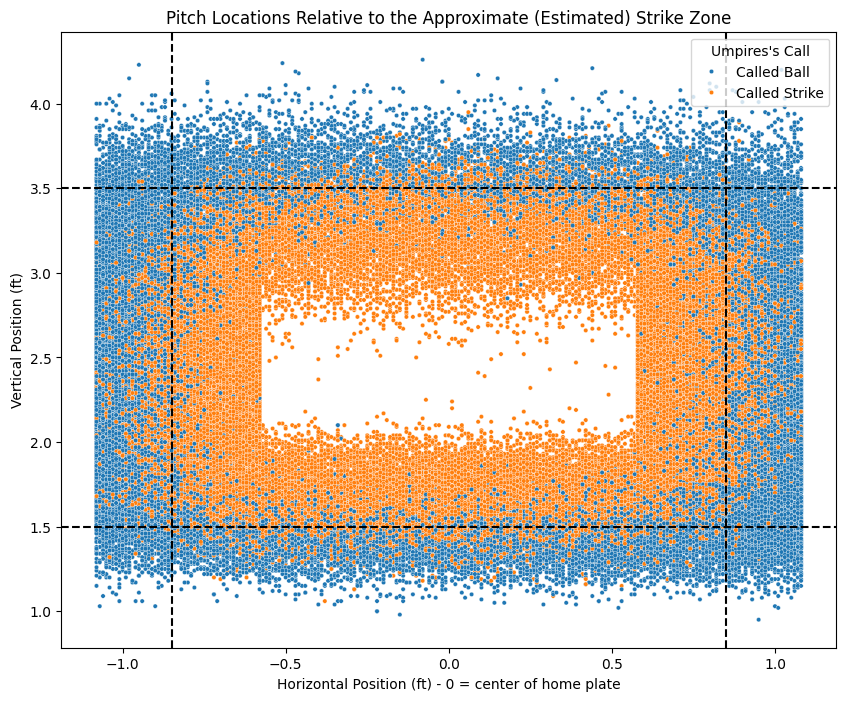

In [30]:
close_calls = close_calls.copy() 
close_calls.loc[:, 'call_label'] = close_calls['type'].map({1: "Called Strike", 0: "Called Ball"})

plt.figure(figsize=(10,8))
sns.scatterplot(x='plate_x', y='plate_z', hue='call_label', data=close_calls, s=10)
plt.title('Pitch Locations Relative to the Approximate (Estimated) Strike Zone')
plt.gca().set(xlabel='Horizontal Position (ft) - 0 = center of home plate', ylabel='Vertical Position (ft)')
plt.axvline(x=0.85, color='black', linestyle='--')
plt.axvline(x=-0.85, color='black', linestyle='--')
plt.axhline(y=1.5, color='black', linestyle='--')
plt.axhline(y=3.5, color='black', linestyle='--')
plt.legend(title="Umpires's Call")
plt.show()

## Exploratory Data Analysis - Final Results and Conclusions:  
Exploratory data analysis was used learn more about the dataset and to focus the dataset to pitches that are within 3 inches of the strike zone border. We now have about 115k rows in our dataset, 56% of which are strikes.  

I will move on to feature engineering to add some attributes that we will need in the model. I will also use the opportunity to remove the rows that do not specify metrics on the pitch and we won't be using in the model.

---  

&nbsp;  
  

## Feature Engineering:  
I'm going to calculate the following columns:  
*  "true_strike" - specifies if a pitch crossed the plate in the objectively defined strike zone.
*  "misclassified" - categorizes if a pitch was correcty called based on the true_strike definition


In [39]:
from IPython.display import display

columns_to_keep = [
    'plate_x', 'plate_z', 'sz_top', 'sz_bot', 'release_speed', 
    'release_pos_x', 'release_pos_y', 'release_pos_z', 'pfx_x', 
    'pfx_z', 'stand', 'p_throws', 'pitch_type', 'type'
]

# Create a copy of the close_calls DataFrame with only relevant columns
model_data = close_calls[columns_to_keep].copy()

# Define true strikes based on the Statcast strike zone
model_data['true_strike'] = (
    (model_data['plate_x'].abs() <= 0.83) &  # Within horizontal limits
    (model_data['plate_z'] >= model_data['sz_bot']) &  # Above bottom limit
    (model_data['plate_z'] <= model_data['sz_top'])  # Below top limit
)

# Define misclassified pitches (both directions)
model_data['misclassified'] = (
    ((model_data['type'] == 0) & (model_data['true_strike'])) |  # True strike called a ball
    ((model_data['type'] == 1) & (~model_data['true_strike']))   # True ball called a strike
)

display(model_data)

,plate_x,plate_z,sz_top,sz_bot,release_speed,release_pos_x,release_pos_y,release_pos_z,pfx_x,pfx_z,stand,p_throws,pitch_type,type,true_strike,misclassified
4,-1.06,2.70,3.93,1.90,93.3,1.96,53.67,5.92,1.55,0.06,R,L,SI,0,False,False
5,0.88,1.47,3.46,1.64,89.5,-2.20,54.26,5.45,0.76,0.29,R,R,FC,0,False,False
10,-0.79,3.65,3.45,1.64,82.0,-2.34,54.66,5.53,1.43,-0.27,R,R,ST,0,False,False
14,0.41,1.58,3.20,1.52,95.9,-2.85,53.66,4.49,-0.96,1.52,R,R,FF,1,True,False
27,-1.02,2.42,3.65,1.70,94.0,1.35,53.43,6.51,0.14,0.58,L,L,FC,0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350468,0.33,1.43,3.10,1.56,91.5,-1.51,53.79,5.61,-1.03,1.66,L,R,FF,0,False,False
350471,1.07,1.75,3.21,1.52,90.8,-1.40,53.61,5.68,-0.97,1.45,R,R,FF,0,False,False
350472,-0.95,2.55,3.44,1.58,96.7,-3.11,55.02,5.40,-1.03,1.37,L,R,FF,1,False,True
350474,-0.99,2.71,3.35,1.58,95.3,-3.11,54.93,5.24,-1.69,0.46,L,R,SI,1,False,True


In [41]:
# Calculate total number of close calls
total_close_calls = len(model_data)

# Calculate total number of misclassified calls
total_misclassified = model_data['misclassified'].sum()

# Calculate misclassification rate
misclassification_rate = (total_misclassified / total_close_calls) * 100

# Create summary statistics
misclassification_summary = {
    "Total Close Calls": int(total_close_calls),
    "Total Misclassified Calls": int(total_misclassified),
    "Misclassification Rate (%)": float(round(misclassification_rate, 2))
}

# Display results
misclassification_summary

{'Total Close Calls': 115924,
 'Total Misclassified Calls': 27106,
 'Misclassification Rate (%)': 23.38}

Looks like we have a misclassification rate of 23%, let's move on to modeling.


&nbsp;  

---  

&nbsp;  
  

# Models:  

Strategy summary:  
*  We are building a classification model to predict 'misclassified' (1 = incorrect call, 0 = correct call).
*  We have defined the feature set for this model and created a focused dataframe with those features.
*  We will start with some preprocessing of the features including
    *  encoding categorical variables (stand, p_throws, pitch_type)
    *  normalize numerical features (release_speed, plate_x, etc)
    *  split dataset into 80/20 train/test sets
*  We will then move on to modeling
    *  I'll start with a logistic regression to get a baseline
    *  Then move to a Random Forest model and assess the results.
    *  Move on to more complex models if we need better accuracy.


### Preprocessing

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [104]:
# Define feature columns (excluding target variable 'misclassified')
feature_columns = [
    'plate_x', 'plate_z', 'sz_top', 'sz_bot', 'release_speed', 
    'release_pos_x', 'release_pos_y', 'release_pos_z', 'pfx_x', 'pfx_z', 
    'stand', 'p_throws', 'pitch_type', 'true_strike'
]

# Separate features (X) and target variable (y)
X = model_data[feature_columns].copy()
y = model_data['misclassified']

# One-hot encode categorical features ('stand', 'p_throws', 'pitch_type')
categorical_features = ['stand', 'p_throws', 'pitch_type']
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_categorical = encoder.fit_transform(X[categorical_features])

# Convert to DataFrame and add column names
encoded_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_features))

# Drop original categorical columns and merge with encoded features
X = X.drop(columns=categorical_features).reset_index(drop=True)
y = y.reset_index(drop=True)
X = pd.concat([X, encoded_df], axis=1)

# Standardize numerical features
scaler = StandardScaler()
numerical_features = ['plate_x', 'plate_z', 'sz_top', 'sz_bot', 'release_speed', 
                      'release_pos_x', 'release_pos_y', 'release_pos_z', 'pfx_x', 'pfx_z']

X[numerical_features] = scaler.fit_transform(X[numerical_features])

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train['true_strike'] = X_train['true_strike'].astype(int)
X_test['true_strike'] = X_test['true_strike'].astype(int)

pd.set_option('display.max_columns', None)  # Show all columns
display(X_train)
pd.reset_option('display.max_columns')

,plate_x,plate_z,sz_top,sz_bot,release_speed,release_pos_x,release_pos_y,release_pos_z,pfx_x,pfx_z,true_strike,stand_R,p_throws_R,pitch_type_CS,pitch_type_CU,pitch_type_EP,pitch_type_FA,pitch_type_FC,pitch_type_FF,pitch_type_FO,pitch_type_FS,pitch_type_KC,pitch_type_KN,pitch_type_SC,pitch_type_SI,pitch_type_SL,pitch_type_ST,pitch_type_SV
9367,0.398602,1.845665,0.430094,0.468589,-2.123926,-0.186446,0.323383,-0.161667,0.921487,-0.634510,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
58640,-0.939269,0.891104,0.282564,-0.603361,-0.474472,1.432294,0.582337,1.212720,-0.305435,-0.095651,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98652,-1.192760,0.683590,0.725153,0.551047,-1.942486,-0.693324,1.985003,-0.216642,1.557256,-2.477977,1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94413,-0.615363,-0.727500,1.020213,0.880878,0.020364,-0.600669,-0.820330,-1.169551,-1.141973,0.670097,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3707,0.581679,1.333799,0.331741,-0.438446,-0.309527,1.563101,-0.172945,-0.454869,1.813795,-0.393442,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76820,-0.713943,-1.336206,0.872683,-0.603361,-1.282705,1.781113,0.776552,-1.389453,0.040334,-0.903940,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
110268,-0.995600,1.416804,0.430094,0.963336,0.069847,-0.824131,-0.172945,-1.151225,-0.193897,0.003613,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103694,-0.868854,-0.450816,-0.996028,-0.191072,-1.266210,-0.862283,1.488675,-1.187876,1.646487,-1.300994,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
860,-0.967434,0.074885,-0.307555,0.303674,-0.392000,-0.240949,-0.129786,0.992818,0.709564,-1.456980,1,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Logistic Regression

In [105]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

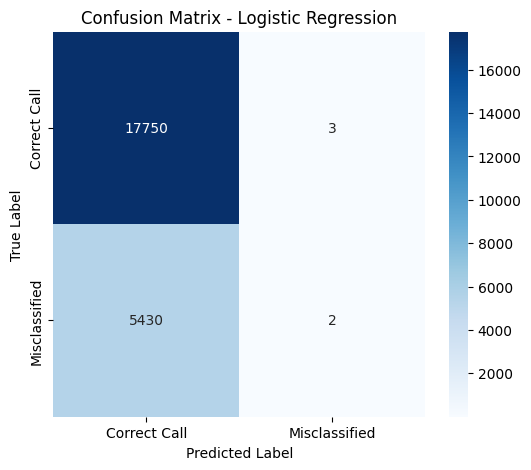

,precision,recall,f1-score,support
False,0.765746,0.999831,0.867271,17753.000000
True,0.400000,0.000368,0.000736,5432.000000
accuracy,0.765667,0.765667,0.765667,0.765667
macro avg,0.582873,0.500100,0.434003,23185.000000
weighted avg,0.680056,0.765667,0.664251,23185.000000


array([[17750,     3],
       [ 5430,     2]])

In [106]:
# Re-run Logistic Regression after handling NaNs
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display confusion matrix as a heatmap
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Correct Call', 'Misclassified'], yticklabels=['Correct Call', 'Misclassified'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Generate a more readable classification report
class_report = classification_report(y_test, y_pred, output_dict=True)
class_report_df = pd.DataFrame(class_report).transpose()

display(class_report_df)
conf_matrix

### Which features are contributing and significant to the Logistic Regression Model?

C:\Users\hurle\AppData\Local\Temp\ipykernel_11716\145019455.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='coolwarm')


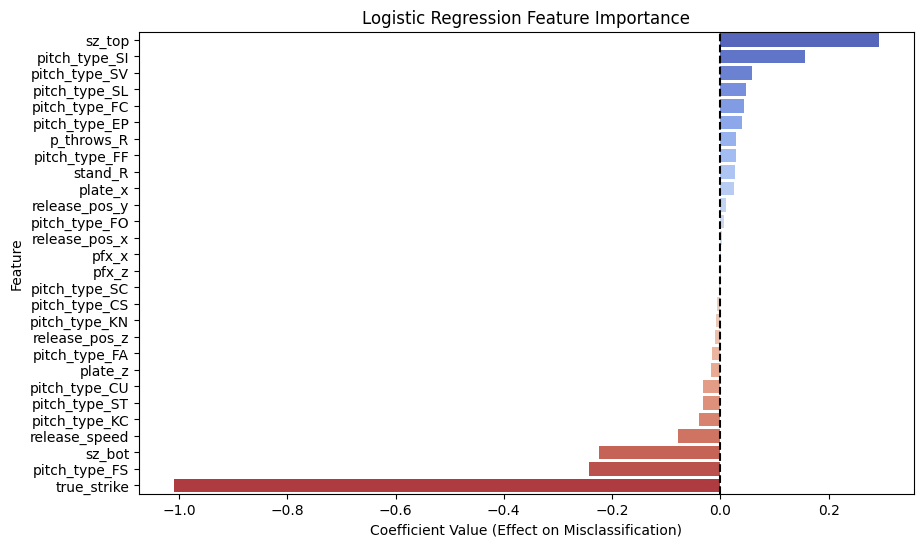

,Feature,Coefficient
2,sz_top,0.292480
24,pitch_type_SI,0.157289
27,pitch_type_SV,0.058942
25,pitch_type_SL,0.048012
17,pitch_type_FC,0.043633
15,pitch_type_EP,0.040161
12,p_throws_R,0.029195
18,pitch_type_FF,0.029104
11,stand_R,0.026660
0,plate_x,0.025425


In [107]:

# Extract feature coefficients from the trained logistic regression model
coefficients = log_reg.coef_[0]
feature_names = X_train.columns

# Create a DataFrame for visualization
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='coolwarm')
plt.axvline(x=0, color='black', linestyle='--')  # Reference line at zero
plt.xlabel("Coefficient Value (Effect on Misclassification)")
plt.ylabel("Feature")
plt.title("Logistic Regression Feature Importance")
plt.show()

display(coef_df)

In [108]:
import statsmodels.api as sm

# Add constant for intercept
X_train_const = sm.add_constant(X_train)

# Fit logistic regression
logit_model = sm.Logit(y_train, X_train_const)
result = logit_model.fit()

# Convert p-values to decimal format and sort from lowest to highest
p_values_df = pd.DataFrame(result.pvalues, columns=['p-value'])

# Format p-values to display in standard decimal notation
p_values_df['p-value'] = p_values_df['p-value'].apply(lambda x: f"{x:.10f}")

# Sort p-values in ascending order
p_values_df = p_values_df.sort_values(by='p-value', ascending=True)

# Display p-values
display(p_values_df)

Optimization terminated successfully.
         Current function value: 0.520130
         Iterations 6


,p-value
const,0.0000000000
sz_top,0.0000000000
sz_bot,0.0000000000
true_strike,0.0000000000
release_speed,0.0000058289
pitch_type_SI,0.0000143898
plate_x,0.0016482706
pitch_type_FS,0.0148861388
plate_z,0.0297120159
pitch_type_SL,0.0478021016


### Logistic regression interpretation:  
The Logistic Regression (LR) model missed most of the misclassified data points. This was a good model to start with so we could get an indication of what might be contributing to misclassifications.  
  
A few things we can learn from this (based on p-values):  
*  pitch_types don't seem to make a significant impact
    * this might be because their characteristics are represented in other features like speed, movement, etc.
*  sz_top and sz_bot seem to have a huge impact on misclassified pitches.
    * sz_top and sz_bot are dependent on the hitters height, and change from hitter to hitter, which may cause issues for umpires (who are human afterall)
*  even though there appear to be a lot of features that are insignificant to the logistic regression model, I'm going to keep the datasets the same moving in to the Random Forest model.

### Random Forest Model

,precision,recall,f1-score,support
False,0.833276,0.954092,0.889601,17753.000000
True,0.714836,0.376105,0.492883,5432.000000
accuracy,0.818676,0.818676,0.818676,0.818676
macro avg,0.774056,0.665098,0.691242,23185.000000
weighted avg,0.805527,0.818676,0.796654,23185.000000


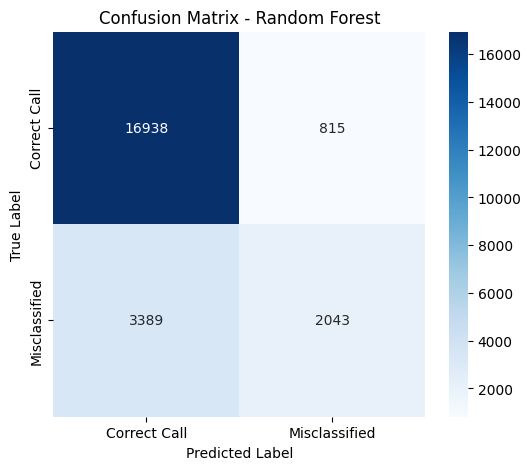

In [109]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf)

# Display results
rf_results = {
    "Accuracy": round(accuracy_rf, 4),
    "Confusion Matrix": conf_matrix_rf,
    "Classification Report": class_report_rf
}

# Display classification report as a DataFrame
report_df = pd.DataFrame(classification_report(y_test, y_pred_rf, output_dict=True)).transpose()

display(report_df)

# Show confusion matrix visually
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Correct Call', 'Misclassified'], yticklabels=['Correct Call', 'Misclassified'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest")
plt.show()


### XGBoost Model

In [114]:
!pip install xgboost
from xgboost import XGBClassifier


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\hurle\OneDrive\MSDS_Colorado\DTSA 550X - CS Pathway\DTSA 5509 - Intro to Machine Learning\FinalProject\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:29:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,precision,recall,f1-score,support
False,0.855184,0.927393,0.889826,17753.000000
True,0.672260,0.486745,0.564656,5432.000000
accuracy,0.824154,0.824154,0.824154,0.824154
macro avg,0.763722,0.707069,0.727241,23185.000000
weighted avg,0.812327,0.824154,0.813642,23185.000000


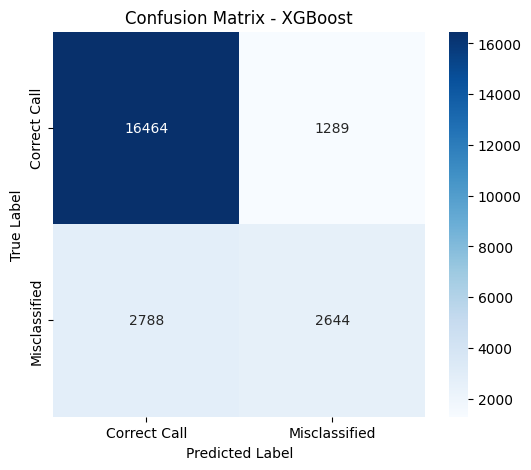

{'XGBoost Accuracy': 0.8242}

In [115]:
# Initialize and train the XGBoost model
xgb_model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
class_report_xgb = classification_report(y_test, y_pred_xgb, output_dict=True)

# Display classification report as a DataFrame
import pandas as pd
report_df_xgb = pd.DataFrame(class_report_xgb).transpose()

display(report_df_xgb)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Correct Call', 'Misclassified'], yticklabels=['Correct Call', 'Misclassified'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - XGBoost")
plt.show()

# Display overall accuracy
{"XGBoost Accuracy": round(accuracy_xgb, 4)}

### XGBoost - Hyperparameter Tuning:

Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\hurle\OneDrive\MSDS_Colorado\DTSA 550X - CS Pathway\DTSA 5509 - Intro to Machine Learning\FinalProject\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:45:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\hurle\OneDrive\MSDS_Colorado\DTSA 550X - CS Pathway\DTSA 5509 - Intro to Machine Learning\FinalProject\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:45:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,precision,recall,f1-score,support
False,0.904370,0.810229,0.854715,17753.000000
True,0.537225,0.719993,0.615324,5432.000000
accuracy,0.789088,0.789088,0.789088,0.789088
macro avg,0.720797,0.765111,0.735020,23185.000000
weighted avg,0.818352,0.789088,0.798628,23185.000000


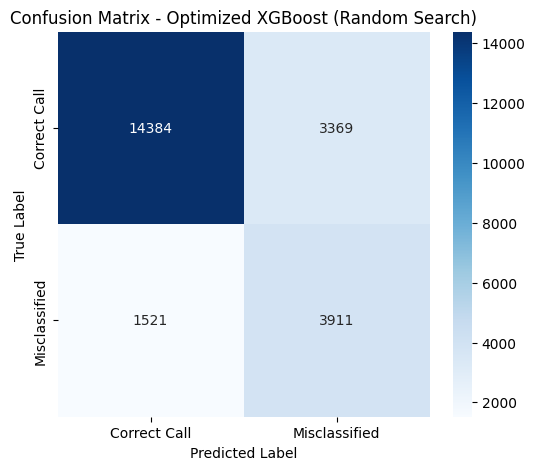

{'subsample': 1.0,
 'scale_pos_weight': 3.2788133247208635,
 'n_estimators': 500,
 'max_depth': 7,
 'learning_rate': 0.1,
 'colsample_bytree': 0.8}

In [117]:
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameter space for Randomized Search
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [1, sum(y_train == 0) / sum(y_train == 1)]  # Handle class imbalance
}

# Initialize the XGBoost classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

# Perform Randomized Search with 20 iterations
random_search = RandomizedSearchCV(
    xgb_model, param_distributions=param_dist, n_iter=20, 
    scoring='f1_macro', cv=3, n_jobs=-1, verbose=2, random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Get best parameters from Randomized Search
best_params_random = random_search.best_params_

# Train XGBoost with the best parameters found
best_xgb_random = XGBClassifier(**best_params_random, use_label_encoder=False, eval_metric="logloss", random_state=42)
best_xgb_random.fit(X_train, y_train)

# Make predictions with optimized model
y_pred_best_xgb_random = best_xgb_random.predict(X_test)

# Evaluate optimized model
accuracy_best_xgb_random = accuracy_score(y_test, y_pred_best_xgb_random)
conf_matrix_best_xgb_random = confusion_matrix(y_test, y_pred_best_xgb_random)
class_report_best_xgb_random = classification_report(y_test, y_pred_best_xgb_random, output_dict=True)

report_df_best_xgb_random = pd.DataFrame(class_report_best_xgb_random).transpose()
display(report_df_best_xgb_random)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix_best_xgb_random, annot=True, fmt='d', cmap='Blues', xticklabels=['Correct Call', 'Misclassified'], yticklabels=['Correct Call', 'Misclassified'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Optimized XGBoost (Random Search)")
plt.show()

# Display best hyperparameters
best_params_random

### XGBoost - Feature Analysis

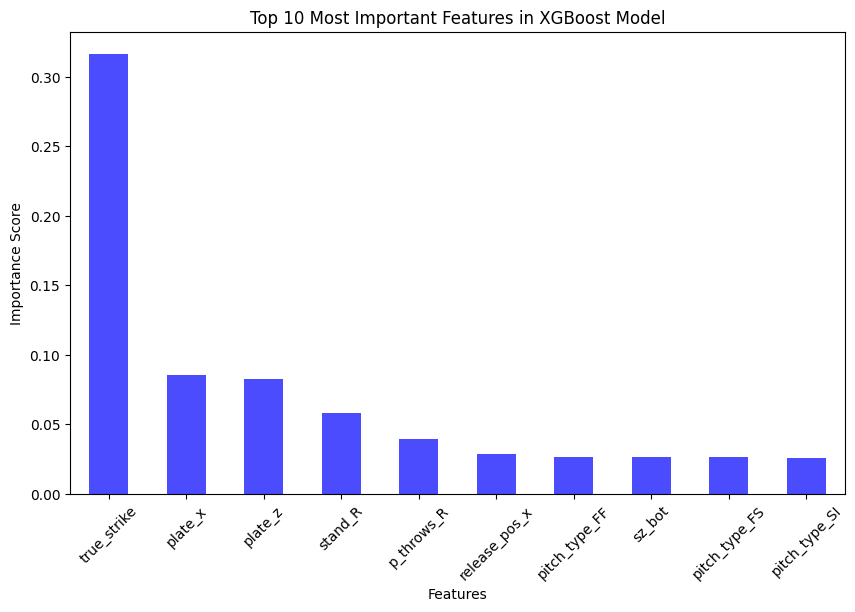

,0
true_strike,0.316408
plate_x,0.085530
plate_z,0.082293
stand_R,0.058270
p_throws_R,0.039312
release_pos_x,0.028599
pitch_type_FF,0.026722
sz_bot,0.026654
pitch_type_FS,0.026561
pitch_type_SI,0.025653


In [118]:
# Feature Importance Analysis for XGBoost
importances = pd.Series(best_xgb_random.feature_importances_, index=X_train.columns)

# Sort feature importances from highest to lowest
importances = importances.sort_values(ascending=False)

# Display top 10 features visually
plt.figure(figsize=(10, 6))
importances.head(10).plot(kind='bar', color='blue', alpha=0.7)
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.title("Top 10 Most Important Features in XGBoost Model")
plt.xticks(rotation=45)
plt.show()

display(importances.to_frame())

## Results Interpretation  

XGBoost was the winner as far as which model performed the best. After hyperparameter tuning, we were able to pick up about 70% of the misclassifications. The issue, was that the model was only slightly better than 50% (53.7%) accurate when it did predict a misclassification. The user would have to decide which tradeoff they prefer when setting the hyperparameters, considering the sensitivity can be increased or decreased, but there is a cost in accuracy.  



# Discussion and Conclusion: 

### Did this project accomplish it's goal?  

In the end, given that the data set we are working with is so dynamic and consists of different umpires, different pitchers and different hitters, I am very happy with the performance of the model we were able to build. I set out to see if I could build a model that predicts when an umpire would miss a call, and I think I did that about as well as I had hoped.  

I think this project could provide some value to the baseball world, in particular, to the umpires. It has the potential to provide insight into how they might improve how they are calling balls and strikes.

### What I learned in the project  

This was a great learning experience for me. I was able to build off of prior projects from the supervised and unsupervised modeling courses. As part of the data collection, I had to find a source for the home plate umpire for each game and merge that with the pybaseball data. In addition to that, I was able to further build python knowledge and experience.  

### Future works and ways to build off this project

There are actually quite a few ways to further analyze this data. It would be interesting to group by pitchers or hitters to see there were any biases for or against individuals when calling balls and strikes.

### Parting Words
I hope you enjoyed reading this project as much as I enjoyed creating it. I'm facscinated by the application of data science to the sport that I love and will continue to use baseball as the foundation of future projects. Thanks for reading!!